In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from matplotlib.pyplot import imshow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras import layers, models, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import MeanAbsoluteError, MeanAbsolutePercentageError
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import History
from sklearn.preprocessing import MinMaxScaler
import tensorflow_addons as tfa
import numpy as np
import pandas as pd
import cv2

C:\Users\talha\anaconda3\envs\EffNet\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.5.3 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
from pathlib import Path
import os
import seaborn as sns
from typing import Iterator, List, Union, Tuple
from datetime import datetime
from sklearn.model_selection import train_test_split
import json

In [3]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler


## Data Collection

In [42]:
def get_water_data() -> pd.DataFrame:
    countries_list_nme = get_selected_africa_coutries_list()
    processed_path = Path(str(Path(os.getcwd()).parent.absolute()) + '/WaterProcessed')
    country_list = sorted(processed_path.glob('*'))
    data = []
    for i in country_list:
        f = open(str(i))
        water_data = json.load(f)
        country_name =  str(i).split('\\')[-1].split('.')[-2][:-5].replace('_', ' ')
        water_data['country_nme'] = country_name
        if country_name in countries_list_nme:
            data.append(water_data)
    water_df = pd.DataFrame(data=data)
    water_df = water_df.set_index('country_nme')
    return water_df

def get_ndvi_evi_data() -> [pd.DataFrame, pd.DataFrame]:
    countries_list_nme = get_selected_africa_coutries_list()
    processed_path = Path(str(Path(os.getcwd()).parent.absolute()) + '/NDVI/Processed_edvi_data')
    country_list = sorted(processed_path.glob('*'))
    ndvi = []
    evi = []
    ndvi_index_list = None
    evi_index_list = None
    for country in country_list:
        data_list = sorted(country.glob('*.csv'))
        country_nme = str(country).split('\\')[-1]
        country_nme = country_nme.replace('_', ' ')
        if country_nme not in countries_list_nme:
            continue
        for i in data_list:
            file_name = str(i).split('\\')[-1].split('_')[0]
            temp_data = pd.read_csv(str(i), index_col = 0)
            temp_data.columns = [country_nme]

            if file_name == 'NDVI':
                if ndvi_index_list is None:
                    ndvi_index_list = temp_data.index.tolist()
                temp_data = temp_data.reset_index(drop=True)
                ndvi.append(temp_data)
            else:
                if evi_index_list is None:
                    evi_index_list = temp_data.index.tolist()
                temp_data = temp_data.reset_index(drop=True)
                evi.append(temp_data)
    ndvi_df = pd.concat(ndvi, axis=1)
    evi_df = pd.concat(evi, axis=1)
    ndvi_df.index = ndvi_index_list
    evi_df.index = evi_index_list
    return ndvi_df, evi_df


def ndvi_evi_monthly_to_yearly(ndvi, evi):
    ndvi = ndvi.reset_index()
    evi = evi.reset_index()

    ndvi['year'] = ndvi['index'].apply(lambda x: x[:4])
    evi['year'] = evi['index'].apply(lambda x: x[:4])

    ndvi_mean_df = ndvi.groupby(['year']).mean()
    ndvi_max_df = ndvi.groupby(['year']).max()
    ndvi_min_df = ndvi.groupby(['year']).min()

    evi_mean_df = evi.groupby(['year']).mean()
    evi_max_df = evi.groupby(['year']).max()
    evi_min_df = evi.groupby(['year']).min()

    # ndvi_mean_df = ndvi_mean_df.drop(columns=['index'])
    ndvi_max_df = ndvi_max_df.drop(columns=['index'])
    ndvi_min_df = ndvi_min_df.drop(columns=['index'])

    evi_max_df = evi_max_df.drop(columns=['index'])
    evi_min_df = evi_min_df.drop(columns=['index'])

    ndvi_mean_df = ndvi_mean_df.T
    ndvi_max_df = ndvi_max_df.T
    ndvi_min_df = ndvi_min_df.T
    evi_mean_df = evi_mean_df.T
    evi_max_df = evi_max_df.T
    evi_min_df = evi_min_df.T

    return ndvi_mean_df, ndvi_max_df, ndvi_min_df, evi_mean_df, evi_max_df, evi_min_df

def get_selected_africa_coutries_list() -> list:
    processed_path = Path(str(Path(os.getcwd()).parent.absolute()) + '/PR_Sandbox/data_country_folders')
    country_list = sorted(processed_path.glob('*'))
    return [str(country).split('\\')[-1].replace('_', ' ') for country in country_list]

def get_label_data() -> [pd.DataFrame, MinMaxScaler] :
    label_path = str(Path(os.getcwd()).parent.absolute()) + '/Yield_Data/all_country_crop_yield_tons_per_hectare1.csv'
    df = pd.read_csv(label_path)
    df = df.set_index(['Country Name'])
    df = df.iloc[:, :-3]
    countries_list_nme = get_selected_africa_coutries_list()
    temp2 = [i in countries_list_nme for i in df.index.tolist()]
    df2 = df[temp2]
    print('Data Range Before Scale:',df2.max().max(), ' to ',  df2.min().min())
    scaler = MinMaxScaler(feature_range=(0, 2))
    temp = df2.copy().to_numpy().reshape(-1, 1)
    scaler = scaler.fit(temp)
    for i in df2.columns.tolist():
        df2.loc[:, i] = scaler.transform(df2[i].values.reshape(-1, 1))
    print('Data Range After Scale:', df2.max().max(), ' to ', df2.min().min())
    return df2, scaler

In [43]:
def data_extraction_and_batching(df_label:pd.DataFrame) -> [list, list, list, list, list, pd.DataFrame, pd.DataFrame]:
    processed_path = Path(str(Path(os.getcwd()).parent.absolute()) + '/PR_Sandbox/data_country_folders')
    country_list = sorted(processed_path.glob('*'))
    train_x, train_y, test_x, valid_x, valid_y = [], [], [], [], []
    water_train_x, water_test_x = [], []
    ndvi_mean_train_x, ndvi_mean_test_x = [], []
    ndvi_max_train_x, ndvi_max_test_x = [], []
    ndvi_min_train_x, ndvi_min_test_x = [], []
    evi_mean_train_x, evi_mean_test_x = [], []
    evi_max_train_x, evi_max_test_x = [], []
    evi_min_train_x, evi_min_test_x = [], []
    year_train_x, year_test_x = [], []
    country_train_x, country_test_x =[],[]

#     counter, sum,counter_new, sum_new= 0, 0, 0, 0

    water_data = get_water_data()
    ndvi, evi =  get_ndvi_evi_data()
    ndvi_mean_df, ndvi_max_df, ndvi_min_df, evi_mean_df, evi_max_df, evi_min_df = ndvi_evi_monthly_to_yearly(ndvi, evi)

    scaler_data = None
    for country in country_list:
        if '.' in str(country):
            continue
        data_list = sorted(country.glob('*.npy'))
        country_nme = str(country).split('\\')[-1]
        country_nme = country_nme.replace('_', ' ')

        # if country_nme == 'Madagascar':
        #     print('333')
        try:
            country_label = df_label.loc[country_nme]
            water_label = water_data.loc[country_nme]
            ndvi_mean_label = ndvi_mean_df.loc[country_nme]
            ndvi_max_label = ndvi_max_df.loc[country_nme]
            ndvi_min_label = ndvi_min_df.loc[country_nme]
            evi_mean_label = evi_mean_df.loc[country_nme]
            evi_max_label = evi_max_df.loc[country_nme]
            evi_min_label = evi_min_df.loc[country_nme]

            for i in data_list:
                year = str(i).split('_')[-1][:4]
                data_array = np.load(str(i.absolute()))
#                 for j in data_array:
#                     counter += Counter(j)[0]
#                     sum += len(j)
#                 if scaler_data is None:
#                     scaler_data = data_array
#                 data = np.transpose(data_array)
#                 if resize_dim != 'ori':
#                     data = im.fromarray(data).resize(resize_dim)
#                     data = np.array(data)
#                 for j in data:
#                     counter_new += Counter(j)[0]
#                     sum_new += len(j)
                data_array = cv2.resize(data_array, (224, 224))
                hist_3 = np.zeros((224,224, 3))
                hist_3[:,:,0] = data_array 
                hist_3[:,:,1] = data_array
                hist_3[:,:,2] = data_array
                if year < '2015':
                    train_x.append(hist_3)
                    train_y.append(country_label[year])
                    
                    country_train_x.append(country_nme)
                    
                    water_train_x.append(water_label[year])
                    ndvi_mean_train_x.append(ndvi_mean_label[year])
                    ndvi_max_train_x.append(ndvi_max_label[year])
                    ndvi_min_train_x.append(ndvi_min_label[year])
                    evi_mean_train_x.append(evi_mean_label[year])
                    evi_max_train_x.append(evi_max_label[year])
                    evi_min_train_x.append(evi_min_label[year])
                    year_train_x.append(int(year))

                elif year < '2019':
                    valid_x.append(hist_3)
                    valid_y.append(country_label[year])
                    
                    country_test_x.append(country_nme)

                    water_test_x.append(water_label[year])
                    ndvi_mean_test_x.append(ndvi_mean_label[year])
                    ndvi_max_test_x.append(ndvi_max_label[year])
                    ndvi_min_test_x.append(ndvi_min_label[year])
                    evi_mean_test_x.append(evi_mean_label[year])
                    evi_max_test_x.append(evi_max_label[year])
                    evi_min_test_x.append(evi_min_label[year])
                    year_test_x.append(int(year))

                else:
                    test_x.append(hist_3)
        except KeyError:
            print(country_nme, 'label dataset is missing.', 'Passed ', country_nme, 'data.')
    print('-'*50)
    print('Training dataset sizes:', len(train_x))
    print('Validation dataset sizes:', len(valid_x))
    print('Testing dataset sizes:', len(test_x))
    # print('Number of 0:', counter)
    # print('Number of sum element:', sum)
    # print('Percentage of 0:', counter/sum)
    # print('Number of 0 new:', counter_new)
    # print('Number of sum element new:', sum_new)
    # print('Percentage of 0 new:', counter_new/sum_new)

    hybrid_model_train_data = pd.DataFrame(data={
        'water':water_train_x,
        'ndvi_mean':ndvi_mean_train_x,
        # 'ndvi_max':ndvi_max_train_x,
        # 'ndvi_min':ndvi_min_train_x,
        'evi_mean':evi_mean_train_x,
        # 'evi_max':evi_max_train_x,
        # 'evi_min':evi_min_train_x,
        #'year': year_train_x,
        'country':country_train_x
    })

    hybrid_model_test_data = pd.DataFrame(data={
        'water':water_test_x,
        'ndvi_mean':ndvi_mean_test_x,
        # 'ndvi_max':ndvi_max_test_x,
        # 'ndvi_min':ndvi_min_test_x,
        'evi_mean':evi_mean_test_x,
        # 'evi_max':evi_max_test_x,
        # 'evi_min':evi_min_test_x,
        #'year':year_test_x,
        'country':country_test_x
    })

    return np.array(train_x), np.array(train_y), np.array(test_x), np.array(valid_x), np.array(valid_y), hybrid_model_train_data, hybrid_model_test_data

In [7]:
label_data,scaler = get_label_data()

Data Range Before Scale: 221.0  to  0.2176
Data Range After Scale: 2.0  to  0.0


C:\Users\talha\anaconda3\envs\EffNet\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\talha\anaconda3\envs\EffNet\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\talha\anaconda3\envs\EffNet\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to b

In [57]:
x_train, y_train, x_test, x_valid, y_valid, h_df_train, h_df_test = data_extraction_and_batching(label_data)

Congo label dataset is missing. Passed  Congo data.
--------------------------------------------------
Training dataset sizes: 299
Validation dataset sizes: 23
Testing dataset sizes: 0


In [9]:
h_df_train.head()

,water,ndvi_mean,evi_mean,country
0,178,0.115041,0.083091,Algeria
1,212,0.119968,0.086220,Algeria
2,223,0.122355,0.087475,Algeria
3,199,0.119373,0.085392,Algeria
4,213,0.121695,0.087041,Algeria


In [10]:
h_df_test

,water,ndvi_mean,evi_mean,country
0,218,0.121690,0.087120,Algeria
1,124,0.542868,0.306535,Angola
2,23,0.459748,0.300933,Benin
3,104,0.301978,0.192956,Botswana
4,33,0.338379,0.224385,Burkina Faso
5,178,0.207719,0.141267,Chad
6,108,0.495889,0.323549,Gabon
7,279,0.489793,0.332035,Ghana
8,1293,0.449015,0.265132,Malawi
9,136,0.193783,0.133595,Mali


## Normalize features

In [11]:
zipBinarizer = LabelBinarizer().fit(h_df_train["country"])
trainCategorical = zipBinarizer.transform(h_df_train["country"])
testCategorical = zipBinarizer.transform(h_df_test["country"])

In [12]:
testCategorical.shape

(23, 23)

In [14]:
cs = MinMaxScaler()
cont = ['water','ndvi_mean','evi_mean']
scale = cs.fit(h_df_train[cont])
trainContinuous = scale.transform(h_df_train[cont])
testContinuous = scale.transform(h_df_test[cont])

In [15]:
testX=np.hstack([testContinuous,testCategorical])

In [16]:
trainX=np.hstack([trainContinuous,trainCategorical])

In [17]:
pd.DataFrame(trainX)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.070880,0.011981,0.003260,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.086230,0.021318,0.012720,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.091196,0.025842,0.016517,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.080361,0.020191,0.010218,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.086682,0.024590,0.015203,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,0.204966,0.663273,0.562020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
295,0.194131,0.632242,0.522815,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
296,0.173815,0.590340,0.504178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
297,0.188262,0.602210,0.531614,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Build Model

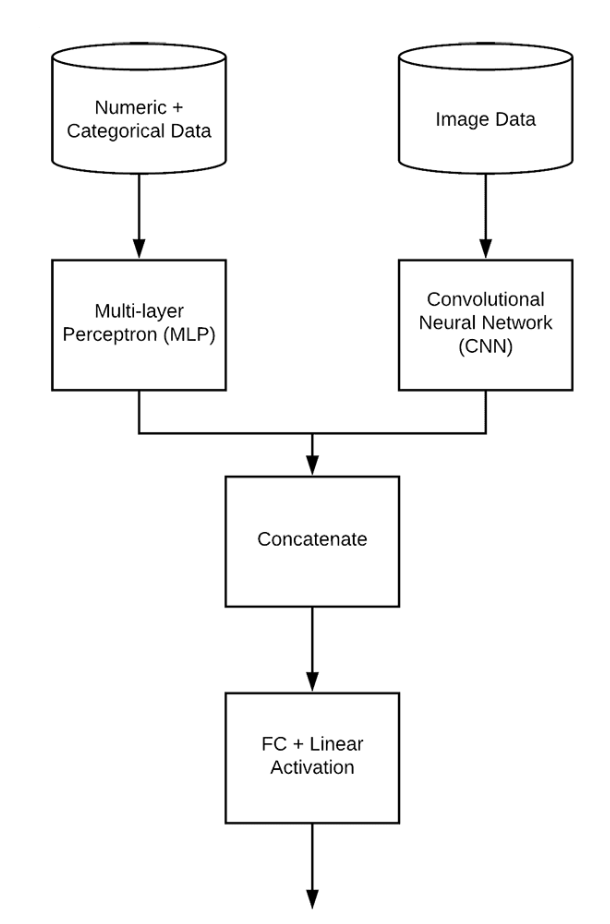
Ref:https://pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

In [44]:
def create_mlp(dim):
    # define multi layer perceptron network
    model = Sequential()
    model.add(layers.Dense(16, input_dim=dim, activation="relu"))
    model.add(layers.Dense(8, activation="relu"))
    model.add(layers.Dense(4, activation="relu"))
    # return model
    return model

def create_cnn(width, height, depth):

    inputShape = (height, width, depth)
    chanDim = -1
    # define the model input
    inputs = layers.Input(shape=inputShape)
    x = inputs
    # CONV => RELU => BN => POOL
    x = layers.Conv2D(16, (3, 3), padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.BatchNormalization(axis=chanDim)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    # repeat with 32
    x = layers.Conv2D(32, (3, 3), padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.BatchNormalization(axis=chanDim)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    #repeat with 64
    x = layers.Conv2D(64, (3, 3), padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.BatchNormalization(axis=chanDim)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    # flatten then, then FC layer => RELU => BN => DROPOUT
    x = layers.Flatten()(x)
    x = layers.Dense(16)(x)
    x = layers.Activation("relu")(x)
    x = layers.BatchNormalization(axis=chanDim)(x)
    x = layers.Dropout(0.5)(x)
    # add another FC layer to match the number of dimensions of MLP output
    x = layers.Dense(4)(x)
    x = layers.Activation("relu")(x)
    
    # construct the CNN
    model = Model(inputs, x)
    
    return model

In [45]:
# create the MLP and CNN models
mlp = create_mlp(trainX.shape[1])
cnn = create_cnn(224, 224, 3)

# output of MLP and CNN combined 
combinedInput = layers.concatenate([mlp.output, cnn.output])

# The combined output is fed to two dense layers with the last one being the regression head
x = layers.Dense(4, activation="relu")(combinedInput)
x = layers.Dense(1, activation="linear")(x)

# construct the combined model
model = Model(inputs=[mlp.input, cnn.input], outputs=x)

# compile the model 
opt = Adam(learning_rate=1e-3, decay=1e-3 / 250)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)

print("Model Training: ")
model.fit(x=[trainX, x_train], y=y_train,validation_data=([testX, x_valid], y_valid),epochs=250, batch_size=4)



Model Training: 
Epoch 1/250
75/75 [==============================] - 8s 92ms/step - loss: 110794.3984 - val_loss: 10248.5869
Epoch 2/250
75/75 [==============================] - 6s 80ms/step - loss: 15518.8828 - val_loss: 5023.6914
Epoch 3/250
75/75 [==============================] - 6s 83ms/step - loss: 43240.0820 - val_loss: 1258.5631
Epoch 4/250
75/75 [==============================] - 6s 81ms/step - loss: 4380.0620 - val_loss: 12487.5801
Epoch 5/250
75/75 [==============================] - 6s 81ms/step - loss: 386877.5938 - val_loss: 6974.2104
Epoch 6/250
75/75 [==============================] - 6s 81ms/step - loss: 175369.4844 - val_loss: 1887.6497
Epoch 7/250
75/75 [==============================] - 6s 84ms/step - loss: 72978.6094 - val_loss: 256.8993
Epoch 8/250
75/75 [==============================] - 6s 84ms/step - loss: 8383.3184 - val_loss: 79.0677
Epoch 9/250
75/75 [==============================] - 6s 87ms/step - loss: 34108.2383 - val_loss: 59.6644
Epoch 10/250
75/75 [==

Epoch 78/250
75/75 [==============================] - 5s 72ms/step - loss: 29376.4316 - val_loss: 63.8379
Epoch 79/250
75/75 [==============================] - 5s 72ms/step - loss: 3661.7249 - val_loss: 85.4245
Epoch 80/250
75/75 [==============================] - 5s 72ms/step - loss: 24275.1562 - val_loss: 71.2770
Epoch 81/250
75/75 [==============================] - 5s 72ms/step - loss: 2464.2954 - val_loss: 258.8072
Epoch 82/250
75/75 [==============================] - 5s 71ms/step - loss: 33712.1758 - val_loss: 52.0044
Epoch 83/250
75/75 [==============================] - 5s 72ms/step - loss: 13263.1270 - val_loss: 253.1909
Epoch 84/250
75/75 [==============================] - 5s 72ms/step - loss: 32564.6250 - val_loss: 53.0148
Epoch 85/250
75/75 [==============================] - 6s 74ms/step - loss: 1781.5496 - val_loss: 105.3289
Epoch 86/250
75/75 [==============================] - 6s 75ms/step - loss: 40732.4922 - val_loss: 76.5447
Epoch 87/250
75/75 [==========================

Epoch 231/250
75/75 [==============================] - 6s 78ms/step - loss: 22202.7637 - val_loss: 117.0490
Epoch 232/250
75/75 [==============================] - 6s 78ms/step - loss: 4941.2822 - val_loss: 60.8906
Epoch 233/250
75/75 [==============================] - 6s 78ms/step - loss: 21504.4883 - val_loss: 126.7525
Epoch 234/250
75/75 [==============================] - 6s 78ms/step - loss: 4932.3530 - val_loss: 66.2482
Epoch 235/250
75/75 [==============================] - 6s 79ms/step - loss: 21289.7734 - val_loss: 122.5853
Epoch 236/250
75/75 [==============================] - 6s 78ms/step - loss: 4224.9453 - val_loss: 66.1417
Epoch 237/250
75/75 [==============================] - 6s 78ms/step - loss: 22666.8457 - val_loss: 118.7218
Epoch 238/250
75/75 [==============================] - 6s 80ms/step - loss: 3674.5698 - val_loss: 66.0778
Epoch 239/250
75/75 [==============================] - 6s 80ms/step - loss: 22201.0664 - val_loss: 95.4052
Epoch 240/250
75/75 [================

## Evaluation

In [55]:
preds = model.predict([testX, x_valid])

In [63]:
print("Model Evaluation: ")
y_valid_inverse = scaler.inverse_transform(y_valid.reshape(-1, 1))
# preds = preds.flatten()
pred_inverse = scaler.inverse_transform(preds.reshape(-1, 1))
percentDiff = ((y_valid_inverse-pred_inverse) / y_valid_inverse) * 100
absPercentDiff = np.abs(percentDiff)

mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)
print("Mean: {:.2f}%, Std: {:.2f}%".format(mean, std))

Model Evaluation: 
Mean: 42.08%, Std: 34.01%


In [64]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
valid_rmse = mean_squared_error(y_valid_inverse, pred_inverse, squared=False)
valid_mape = abs((y_valid_inverse - pred_inverse) / y_valid_inverse).mean()

In [65]:
valid_mape

0.4208307274228231

In [66]:
valid_rmse

0.6567146776633022

MLP and CNN structure referenced from: https://pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/